# rtree

> Rectangle tree for fast point cloud data query

In [ ]:
#| default_exp rtree

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# Some functions adapted from spatialpandas at https://github.com/holoviz/spatialpandas
# under BSD-2-Clause license,

# Further specialized for 2D point cloud data and optimized for zarr.

In [ ]:
#| export
import numpy as np
from numba import float64, int64
from numba import prange
import math
from moraine.utils_ import ngjit, ngpjit
try:
    from numba.experimental import jitclass
except ImportError:
    from numba import jitclass
import zarr

In [ ]:
import moraine as mr

In [ ]:
#| hide
from matplotlib.collections import PatchCollection
import matplotlib
import matplotlib.pyplot as plt
from nbdev import show_doc

In [ ]:
#| export
@ngjit
def _left_child(node):
    """
    Args:
        node: index of a binary tree node

    Returns:
        index of node's left child
    """
    return 2 * node + 1

In [ ]:
#| export
@ngjit
def _right_child(node):
    """
    Args:
        node: index of a binary tree node

    Returns:
        index of node's right child
    """
    return 2 * node + 2

In [ ]:
#| export
@ngjit
def _parent(node):
    """
    Args:
        node: index of a binary tree node

    Returns:
        index of node's parent
    """
    return (node - 1) // 2

In [ ]:
#| export
@ngjit
def _is_outside(query_bounds, node_bounds):
    if (query_bounds[2] < node_bounds[0]) or (query_bounds[0] > node_bounds[2]):
        return True
    if (query_bounds[3] < node_bounds[1]) or (query_bounds[1] > node_bounds[3]):
        return True
    return False

In [ ]:
#| hide
assert _is_outside(np.array([0.5,0.5,0.6,0.6]), np.array([0.24330907,0.02271734,0.90802693,0.33264098]))

In [ ]:
#| export
@ngjit
def _is_inside(query_bounds, node_bounds):
    if ((query_bounds[0] < node_bounds[0]) and (query_bounds[2] > node_bounds[2]) and
        (query_bounds[1] < node_bounds[1]) and (query_bounds[3] > node_bounds[3])):
        return True
    else:
        return False

In [ ]:
#| hide
assert not _is_inside(np.array([0.5,0.5,0.6,0.6]), np.array([0.22144525,0.06039695,0.97828617,0.99201584]))

In [ ]:
#| export
@ngpjit
def _is_inside_bf(bounds, x, y):
    out = np.empty(x.shape,np.bool_)
    for i in prange(x.size):
        x_i = x[i]; y_i = y[i]
        if (x_i>bounds[0]) and (x_i<bounds[2]) and (y_i>bounds[1]) and (y_i<bounds[3]):
            out[i] = True
        else:
            out[i] = False
    return out

In [ ]:
#| hide
bounds = np.array([0.5,0.5,0.6,0.6])
x = np.array([0.55,0.58,0.55,0.8])
y = np.array([0.8,0.52,0.58,0.55])
assert np.all(_is_inside_bf(bounds,x,y) == np.array([False,True,True,False]))

In [ ]:
#| export
@ngpjit
def _build_hillbert_rtree(x, y, page_size):
    """
        Construct a hillbert rtree, the input coordinates has already been
        sorted according to the hillbert index. Reture the bounds tree
        Args:
            x: x coordinates (e.g., longitude)
            y: y coordinates (e.g., latitude)
            page_size: Number of elements per leaf of the tree.
    """
    # Init bounds_tree array for storing the binary tree representation
    input_size = x.shape[0]
    num_pages = math.ceil(input_size/page_size)

    tree_depth = math.ceil(np.log2(num_pages))
    next_pow2 = 2 ** tree_depth
    tree_length = next_pow2 * 2 - 1
    bounds_tree = np.full((tree_length, 4), np.nan)
    leaf_start = tree_length - next_pow2

    for page in prange(num_pages):
        start = page * page_size
        stop = start + page_size
        page_x = x[start:stop]; page_y = y[start:stop]
        bounds_tree[leaf_start + page, 0] = np.min(page_x)
        bounds_tree[leaf_start + page, 1] = np.min(page_y)
        bounds_tree[leaf_start + page, 2] = np.max(page_x)
        bounds_tree[leaf_start + page, 3] = np.max(page_y)

    # Populate internal layers of tree
    layer = tree_depth - 1
    start = _parent(tree_length - next_pow2)
    stop = _parent(tree_length - 1)

    while layer >= 0:
        for node in prange(start, stop + 1):
            left_bounds = bounds_tree[_left_child(node), :]
            left_valid = not np.isnan(left_bounds[0])
            right_bounds = bounds_tree[_right_child(node), :]
            right_valid = not np.isnan(right_bounds[0])

            if left_valid:
                if right_valid:
                    bounds_tree[node, 0] = min(left_bounds[0],right_bounds[0])
                    bounds_tree[node, 1] = min(left_bounds[1],right_bounds[1])
                    bounds_tree[node, 2] = max(left_bounds[2],right_bounds[2])
                    bounds_tree[node, 3] = max(left_bounds[3],right_bounds[3])
                else:
                    bounds_tree[node, :] = left_bounds

            elif right_valid:
                bounds_tree[node, :] = right_bounds

        # update layer, start/stop
        start = _parent(start)
        stop = _parent(stop)
        layer -= 1

    return bounds_tree

In [ ]:
#| export
@ngjit
def _merge_ranges(ranges,is_covered):
    merged_ranges = [ranges[0]]
    merged_is_covered = [is_covered[0]]
    for _range, _is_covered in zip(ranges[1:],is_covered[1:]):
        if (merged_ranges[-1][1] == _range[0]) and (merged_is_covered[-1] == _is_covered):
            merged_ranges[-1] = (merged_ranges[-1][0], _range[1])
        else:
            merged_ranges.append(_range)
            merged_is_covered.append(_is_covered)
    return merged_ranges, merged_is_covered

In [ ]:
#| export
@ngjit
def _expand_ranges(ranges):
    length = np.sum(ranges[:,1]-ranges[:,0])
    idx = np.zeros(length,dtype=np.int64)
    idx_start = 0
    for i in range(ranges.shape[0]):
        start = ranges[i,0]
        stop = ranges[i,1]
        size = stop-start
        idx[idx_start:idx_start+size] = np.arange(start,stop,dtype=np.int64)
        idx_start += size
    return idx

In [ ]:
#| hide
ranges = np.array([[0,2],
                   [3,6],
                   [8,10],
                   ])
np.testing.assert_array_equal(_expand_ranges(ranges), np.array([0, 1, 3, 4, 5, 8, 9]))

In [ ]:
#| export
#| hide
_numbartree_spec = [
    ('_bounds_tree', float64[:, :]),
    ('_n_points', int64),
    ('_page_size', int64),
]
# @jitclass(_numbartree_spec)
class _NumbaRtree:
    def __init__(self, bounds_tree, n_points, page_size):
        self._bounds_tree = bounds_tree
        self._n_points = n_points
        self._page_size = page_size

    def _leaf_start(self):
        """
        Returns
            Index of the first leaf node in bounds_tree
        """
        return (self._bounds_tree.shape[0] + 1) // 2 - 1

    def _start_index(self, node):
        """
        Args
            node: Index into _bounds_tree representing a binary tree node
        Returns
            The first index into keys represented by node
        """
        leaf_start = self._leaf_start()
        while True:
            child = _left_child(node)
            if child >= self._bounds_tree.shape[0]:
                page = node - leaf_start
                return page * self._page_size
            else:
                node = child

    def _stop_index(self, node):
        """
        Args
            node: Index into _bounds_tree representing a binary tree node
        Returns
            One past the last index into keys represented by node
        """
        leaf_start = self._leaf_start()
        while True:
            child = _right_child(node)
            if child >= self._bounds_tree.shape[0]:
                page = node - leaf_start + 1
                return page * self._page_size
            else:
                node = child

    def _maybe_covered_ranges(self, query_bounds):
        if len(query_bounds) % 2 != 0:
            raise ValueError(
                'query_bounds must an array with an even number of elements'
            )
        nodes = [0]
        maybe_covered_ranges = []
        is_covered = []
        # Find ranges of indices that overlap with query bounds
        while nodes:
            next_node = nodes.pop()
            node_bounds = self._bounds_tree[next_node, :]
            if np.all(np.isnan(node_bounds)): # remove empty bounds
                continue

            # Check if node's bounds are fully outside query bounds
            outside = _is_outside(query_bounds, node_bounds)
            if outside:
                continue

            # Check if node's bounds are fully inside query bounds
            inside = _is_inside(query_bounds, node_bounds)

            if inside:
                # Node's bounds are fully inside query bounds
                start = self._start_index(next_node)
                stop = self._stop_index(next_node)
                maybe_covered_ranges.append((start, stop))
                is_covered.append(True)
            else:
                # print(f'not inside or outsize: {node_bounds}')
                start = self._start_index(next_node)
                stop = self._stop_index(next_node)
                # print(self._page_size)
                if stop - start <= self._page_size:
                    # note that the stop may exceed the true length of the array
                    maybe_covered_ranges.append((start, stop))
                    is_covered.append(False)
                else:
                    # Partial overlap of interior bounding box, recurse to children
                    nodes.extend([_right_child(next_node), _left_child(next_node)])

        if len(maybe_covered_ranges) == 0:
            return np.zeros((0,2),dtype=np.int_), np.array([],dtype=np.bool_)

        # to ensure end do not exceed the true length
        if maybe_covered_ranges[-1][1] > self._n_points:
            maybe_covered_ranges[-1] = (maybe_covered_ranges[-1][0], self._n_points)
        maybe_covered_ranges, is_covered = _merge_ranges(maybe_covered_ranges, is_covered)
        return np.array(maybe_covered_ranges), np.array(is_covered)

In [ ]:
#| export
@ngjit
def _merged_idx(ranges, is_covered, maybe_covered_is_inside):
    max_len = np.sum(ranges[:,1]-ranges[:,0])
    idx = np.zeros(max_len,dtype=np.int64)
    idx_start = 0
    idx_maybe_covered = 0
    for i in range(ranges.shape[0]):
        start = ranges[i,0]
        stop = ranges[i,1]
        size = stop-start
        if is_covered[i]:
            idx[idx_start:idx_start+size] = np.arange(start,stop,dtype=np.int64)
            idx_start += size
        else:
            _idx = np.arange(start,stop,dtype=np.int64)[maybe_covered_is_inside[idx_maybe_covered:idx_maybe_covered+size]]
            idx_maybe_covered += size
            size = len(_idx)
            idx[idx_start:idx_start+size] = _idx
            idx_start += size
    return idx[:idx_start]

In [ ]:
#| export
class HilbertRtree:
    """
    This class provides a read-only Hilbert R-tree for spatial indexing.

    See [Hilbert_R-tree](https://en.wikipedia.org/wiki/Hilbert_R-tree) for more info on the Hilbert R-tree.

    This implementation stores the R-tree as an array representation of a binary tree.
    See [Binary_tree](https://en.wikipedia.org/wiki/Binary_tree#Arrays) for more info on the array
    representation of a binary tree.
    """
    
    def __init__(self, bounds_tree:np.ndarray, # an array representation of a binary tree. shape [n_pages, 4]. Every row is a bounding box of a node: [x0, y0, xm, ym]
                 n_points:int, # number of total points
                 page_size=512, # number of points in every leaf node.
                ):
        '''Note that HilbertRtree should not be instantiated directly, 
        but always through the module-level function `build` and `load`.'''
        self._bounds_tree = bounds_tree
        self._n_points = n_points
        self._page_size = page_size
        self._numba_rtree = _NumbaRtree(
                self._bounds_tree,self._n_points, self._page_size)

    @classmethod
    def build(cls, x:np.ndarray, # x coordinates, e.g., lon, shape [n_points,]
              y:np.ndarray, # y coordinates, e.g., lat, shape [n_points,]
              page_size=512, # number of points in every leaf node. should be same as pc_chunk_size.
             ):
        """classmethod to build a HilbertRtree."""
        assert x.shape == y.shape
        page_size = max(1, page_size)
        bounds_tree = _build_hillbert_rtree(x.astype(np.float64), y.astype(np.float64), page_size)
        return cls(bounds_tree,x.shape[0], page_size)

    def save(self,path:str, # zarr path
            ):
        '''Save the HilbertRtree.'''
        bounds_tree_zarr = zarr.open(path,'w',shape=self._bounds_tree.shape,dtype=self._bounds_tree.dtype)
        bounds_tree_zarr[:] = self._bounds_tree[:]
        bounds_tree_zarr.attrs['page_size'] = self._page_size
        bounds_tree_zarr.attrs['n_points'] = self._n_points

    @classmethod
    def load(cls, zarr_path:str, # zarr path
            ):
        '''classmethod to load the saved HilbertRtree.'''
        bounds_tree_zarr = zarr.open(path,'r')
        return cls(bounds_tree_zarr[:], bounds_tree_zarr.attrs['n_points'], bounds_tree_zarr.attrs['page_size'])

    def __getstate__(self):
        # Remove _NumbaRtree instance during serialization since jitclass instances
        # don't support it.
        state = self.__dict__
        state['_numba_rtree'] = None
        return state
    
    @property
    def bounds_tree(self):
        return self._bounds_tree

    def maybe_covered_ranges(self, bounds:tuple|list, # data query bounding box, [x0, y0, xm, ym]
                             # array of ranges that may be covered by the query bounding box, shape[n_range, 2]. Every row [start, stop] is the range of query data 
                             # Bool array indicating if fully convered, shape[n_range,]. True: fully covered (every point in this range are in the box). False: some of points may be in the box.
                            )->tuple:
        '''Get the ranges that may be within the query box.'''
        bounds = tuple(float(b) for b in bounds)
        return self._numba_rtree._maybe_covered_ranges(bounds)

    def bbox_query(self, bounds:tuple|list, # data query bounding box, [x0, y0, xm, ym]
                   x:np.ndarray|zarr.Array, # x coordinate
                   y:np.ndarray|zarr.Array, # y coordinate
                  ):
        '''get the index of points that are in the bounding box.'''
        bounds = tuple(float(b) for b in bounds)
        ranges, is_covered = self._numba_rtree._maybe_covered_ranges(bounds)
        # if len(ranges) == 0:
        #     return np.array([],dtype=np.int64)
        maybe_covered_ranges = ranges[~is_covered]
        maybe_covered_index = _expand_ranges(maybe_covered_ranges)
        maybe_covered_x = x[maybe_covered_index]
        maybe_covered_y = y[maybe_covered_index]
        maybe_covered_is_inside = _is_inside_bf(bounds,maybe_covered_x,maybe_covered_y)
        return _merged_idx(ranges, is_covered, maybe_covered_is_inside)

In [ ]:
show_doc(HilbertRtree.build)

---

[source](https://github.com/kanglcn/moraine/blob/main/moraine/rtree.py#L328){target="_blank" style="float:right; font-size:smaller"}

### HilbertRtree.build

>      HilbertRtree.build (x:numpy.ndarray, y:numpy.ndarray, page_size=512)

*classmethod to build a HilbertRtree.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| x | ndarray |  | x coordinates, e.g., lon, shape [n_points,] |
| y | ndarray |  | y coordinates, e.g., lat, shape [n_points,] |
| page_size | int | 512 | number of points in every leaf node. should be same as pc_chunk_size. |

In [ ]:
show_doc(HilbertRtree.save)

---

[source](https://github.com/kanglcn/moraine/blob/main/moraine/rtree.py#L338){target="_blank" style="float:right; font-size:smaller"}

### HilbertRtree.save

>      HilbertRtree.save (path:str)

*Save the HilbertRtree.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str | zarr path |

In [ ]:
show_doc(HilbertRtree.load)

---

[source](https://github.com/kanglcn/moraine/blob/main/moraine/rtree.py#L347){target="_blank" style="float:right; font-size:smaller"}

### HilbertRtree.load

>      HilbertRtree.load (zarr_path:str)

*classmethod to load the saved HilbertRtree.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| zarr_path | str | zarr path |

In [ ]:
show_doc(HilbertRtree.bbox_query)

---

[source](https://github.com/kanglcn/moraine/blob/main/moraine/rtree.py#L372){target="_blank" style="float:right; font-size:smaller"}

### HilbertRtree.bbox_query

>      HilbertRtree.bbox_query (bounds:tuple|list,
>                               x:numpy.ndarray|zarr.core.Array,
>                               y:numpy.ndarray|zarr.core.Array)

*get the index of points that are in the bounding box.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| bounds | tuple \| list | data query bounding box, [x0, y0, xm, ym] |
| x | numpy.ndarray \| zarr.core.Array | x coordinate |
| y | numpy.ndarray \| zarr.core.Array | y coordinate |

In [ ]:
#| hide
# test for if query return out of bound index
gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100)),axis=-1).astype(np.int32)
hix = mr.pc_hix(gix,shape=(100,100))
key = mr.pc_sort(hix)

x = gix[:,1][key]/100; y = gix[:,0][key]/100 # any kind of coordinates
bbox = [x.min(), y.min(), x.max(), y.max()]
rtree = HilbertRtree.build(x,y,page_size=32)
idx = rtree.bbox_query(bbox,x,y)
assert idx[-1] < 1000

In [ ]:
#| hide
# plt.scatter(x,y,c=np.arange(x.shape[0]))

Example: create the data:

In [ ]:
gix = np.random.randint(0, 10000*10000-1, size=1000000)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(10000,10000)),axis=-1).astype(np.int32)
hix = mr.pc_hix(gix,shape=(10000,10000))
key = mr.pc_sort(hix)

x = gix[:,1][key]/10000; y = gix[:,0][key]/10000 # any kind of coordinates
print(x.min(),y.min(),x.max(),y.max())

0.0 0.0 0.9999 0.9999


build r tree:

In [ ]:
rtree = HilbertRtree.build(x,y,page_size=4096)

data query:

In [ ]:
x0, y0, xm, ym = 0.9, 0.9, 1.0, 1.0
bounds = [x0, y0, xm, ym]
q_idx = rtree.bbox_query(bounds,x,y)

compare with the brute-force check:

In [ ]:
q_idx_ = np.where((x>x0) & (x<xm) & (y>y0) & (y<ym))[0]
np.testing.assert_array_equal(q_idx, q_idx_)

speed compare:

In [ ]:
%%timeit
q_idx = rtree.bbox_query(bounds,x,y)

426 µs ± 2.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit
q_idx_ = np.where((x>x0) & (x<xm) & (y>y0) & (y<ym))[0]

1.22 ms ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


`HilbertRtree` is designed for query small amount of data from a big dataset.
The bigger the dataset, the greater the improvement.

for data on the disk:

In [ ]:
x_zarr = zarr.open('rtree/x.zarr','w',shape=x.shape,chunks=(4096,),dtype=x.dtype)
y_zarr = zarr.open('rtree/y.zarr','w',shape=x.shape,chunks=(4096,),dtype=x.dtype)
x_zarr[:] = x; y_zarr[:] = y

In [ ]:
x_zarr = zarr.open('rtree/x.zarr','r')
y_zarr = zarr.open('rtree/y.zarr','r')

In [ ]:
%%timeit
q_idx = rtree.bbox_query(bounds,x_zarr,y_zarr)

4.6 ms ± 46.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
x = x_zarr[:]; y = y_zarr[:]
idx = np.where((x>x0) & (x<xm) & (y>y0) & (y<ym))[0]

215 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#| hide
ranges, is_covered = rtree.maybe_covered_ranges(bounds)
for _range, _is_covered in zip(ranges, is_covered):
    if _is_covered:
        assert np.all(x[_range[0]:_range[1]]>=x0)
        assert np.all(x[_range[0]:_range[1]]<=xm)
        assert np.all(y[_range[0]:_range[1]]>=y0)
        assert np.all(y[_range[0]:_range[1]]<=ym)
# for _maybe_covered_range in maybe_covered_range:
#     assert np.any(x_sorted[slice(*_maybe_covered_range)]>=x0)
#     assert np.any(x_sorted[slice(*_maybe_covered_range)]<=xm)
#     assert np.any(y_sorted[slice(*_maybe_covered_range)]>=y0)
#     assert np.any(y_sorted[slice(*_maybe_covered_range)]<=ym)

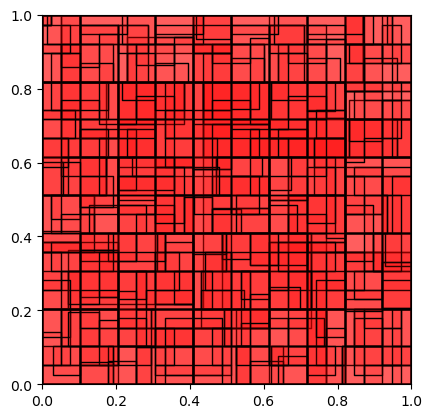

In [ ]:
#| hide
bounds_tree=rtree.bounds_tree
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
n = bounds_tree.shape[0]
patches = []
for i in range(n):
    patches.append(matplotlib.patches.Rectangle((bounds_tree[i,0], bounds_tree[i,1]),bounds_tree[i,2]-bounds_tree[i,0],bounds_tree[i,3]-bounds_tree[i,1],))
ax.add_collection(PatchCollection(patches,fc = (1,0,0,0.1), ec = (0,0,0,1), lw=1 ))
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()